# [Comparaison d'étalonnage de classifieurs](https://scikit-learn.org/stable/auto_examples/calibration/plot_compare_calibration.html)

Les classifieurs bien calibrés sont des classifieurs probabilistes pour lesquels la sortie de `predict_proba` peut être directement interprétée comme un niveau de confiance. Par exemple, un classifieur (binaire) bien calibré devrait classer les échantillons de telle sorte que pour les échantillons auxquels il a donné une valeur `predict_proba` proche de 0,8, environ 80 % appartiennent effectivement à la classe positive.

Dans cet exemple, nous comparerons le calibrage de quatre modèles différents : [régression logistique (1.1.11.)](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression), [bayes naïf gaussien (1.9.1.)](https://scikit-learn.org/stable/modules/naive_bayes.html#gaussian-naive-bayes), [classifieur à forêt aléatoire (1.11.2.)](https://scikit-learn.org/stable/modules/ensemble.html#forest) et [SVM linéaire (1.4.1.)](https://scikit-learn.org/stable/modules/svm.html#svm-classification).

Auteur : Jan Hendrik Metzen <jhm@informatik.uni-bremen.de> Licence : clause BSD 3.

## Jeu de données

Nous utiliserons un ensemble de données de classification binaire synthétique avec 100 000 échantillons et 20 caractéristiques. Sur les 20 caractéristiques, seules 2 sont informatives, 2 sont redondantes (combinaisons aléatoires des caractéristiques informatives) et les 16 autres sont non informatives (nombres aléatoires). Sur les 100 000 échantillons, 100 seront utilisés pour l'ajustement du modèle et le reste pour les tests.

In [1]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=100_000, n_features=20, n_informative=2, n_redundant=2, random_state=42
)

train_samples = 100  # Samples used for training the models
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    shuffle=False,
    test_size=100_000 - train_samples,
)

## Courbes d'étalonnage

Ci-dessous, nous entraînons chacun des quatre modèles avec le petit ensemble de données d'apprentissage, puis traçons des courbes d'étalonnage (également appelées diagrammes de fiabilité) à l'aide des probabilités prédites de l'ensemble de données de test. Les courbes d'étalonnage sont créées en regroupant les probabilités prédites, puis en traçant la probabilité prédite moyenne dans chaque classe par rapport à la fréquence observée ("fraction de positifs"). Sous la courbe d'étalonnage, nous traçons un histogramme montrant la distribution des probabilités prédites ou plus précisément, le nombre d'échantillons dans chaque classe de probabilité prédite.

In [2]:
import numpy as np

from sklearn.svm import LinearSVC

class NaivelyCalibratedLinearSVC(LinearSVC):
    """LinearSVC with `predict_proba` method that naively scales
    `decision_function` output."""

    def fit(self, X, y):
        super().fit(X, y)
        df = self.decision_function(X)
        self.df_min_ = df.min()
        self.df_max_ = df.max()

    def predict_proba(self, X):
        """Min-max scale output of `decision_function` to [0,1]."""
        df = self.decision_function(X)
        calibrated_df = (df - self.df_min_) / (self.df_max_ - self.df_min_)
        proba_pos_class = np.clip(calibrated_df, 0, 1)
        proba_neg_class = 1 - proba_pos_class
        proba = np.c_[proba_neg_class, proba_pos_class]
        return proba

In [3]:
from sklearn.calibration import CalibrationDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

# Create classifiers
lr = LogisticRegression()
gnb = GaussianNB()
svc = NaivelyCalibratedLinearSVC(C=1.0)
rfc = RandomForestClassifier()

clf_list = [
    (lr, "Logistic"),
    (gnb, "Naive Bayes"),
    (svc, "SVC"),
    (rfc, "Random forest"),
]

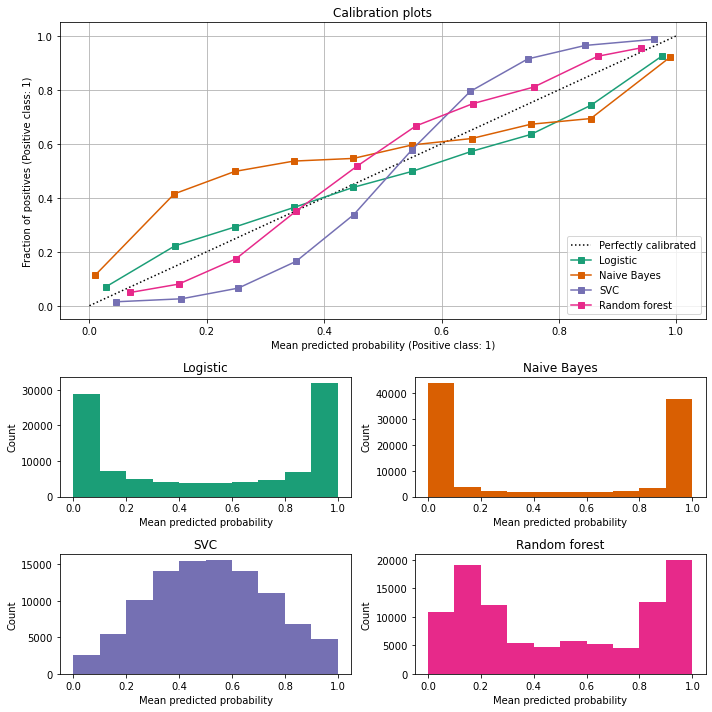

In [4]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

[`LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression) renvoie des prédictions bien calibrées car il optimise directement la perte de log. En revanche, les autres méthodes renvoient des probabilités biaisées, avec des biais différents pour chaque méthode :

* [`GaussianNB`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB) a tendance à pousser les probabilités vers 0 ou 1 (voir histogramme). Cela est principalement dû au fait que l'équation naïve de Bayes ne fournit une estimation correcte des probabilités que lorsque l'hypothèse selon laquelle les caractéristiques sont conditionnellement indépendantes est valable [2]. Cependant, les caractéristiques ont tendance à être positivement corrélées et c'est le cas avec cet ensemble de données, qui contient 2 caractéristiques générées sous forme de combinaisons linéaires aléatoires des caractéristiques informatives. Ces caractéristiques corrélées sont effectivement « comptées deux fois », ce qui pousse les probabilités prédites vers 0 et 1 [3].

* [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier) montre le comportement opposé : les histogrammes montrent des pics autour des probabilités 0,2 et 0,9, alors que les probabilités proches de 0 ou 1 sont très rares. Une explication à cela est donnée par Niculescu-Mizil et Caruana [1] : « Des méthodes telles que le bagging et les forêts aléatoires qui font la moyenne des prédictions à partir d'un ensemble de modèles de base peuvent avoir des difficultés à faire des prédictions proches de 0 et 1 car la variance dans les modèles de base sous-jacents  =vont biaiser les prédictions qui devraient être proches de zéro ou éloignées de ces valeurs. Étant donné que les prédictions sont limitées à l'intervalle [0, 1], les erreurs causées par la variance ont tendance à être unilatérales près de zéro et un. Par exemple, si un modèle doit prédire p = 0 pour un cas, la seule façon dont le bagging peut y parvenir est que tous les arbres bagués prédisent zéro. Si nous ajoutons du bruit aux arbres sur lesquels l'ensachage fait la moyenne, ce bruit amènera certains arbres à prédire des valeurs supérieures à 0 dans ce cas, éloignant ainsi la prédiction moyenne de l'ensemble ensaché de 0. Nous observons cet effet le plus fortement avec les forêts aléatoires parce que les arbres de base entraînés avec des forêts aléatoires ont une variance relativement élevée en raison du sous-ensemble de caractéristiques. En conséquence, la courbe d'étalonnage montre une forme sigmoïde caractéristique, indiquant que le classifieur est sous-confiant et pourrait renvoyer des probabilités plus proches de 0 ou 1.

Pour montrer les performances de [`LinearSVC`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC), nous mettons naïvement à l'échelle la sortie de la [fonction de décision](https://scikit-learn.org/stable/glossary.html#term-decision_function) en [0, 1] en appliquant une mise à l'échelle min-max, puisque SVC ne produit pas de probabilités par défaut. [`LinearSVC`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC) montre une courbe encore plus sigmoïde que [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier), ce qui est typique des méthodes à marge maximale [1] car elles se concentrent sur des échantillons difficiles à classer qui sont proches de la limite de décision (les vecteurs de support).

## Références


[1] (1,2)

[Prédire de bonnes probabilités avec l'apprentissage supervisé](https://dl.acm.org/doi/abs/10.1145/1102351.1102430), A. Niculescu-Mizil & R. Caruana, ICML 2005
[2]

[Au-delà de l'indépendance : conditions d'optimalité du classifieur bayésien simple Domingos](https://www.ics.uci.edu/~pazzani/Publications/mlc96-pedro.pdf), P., & Pazzani, M., Proc. 13e Int. Conf. Apprentissage automatique. 1996.
[3]

[Obtention d'estimations de probabilité calibrées à partir d'arbres de décision et de classifieurs bayésiens naïfs](https://cseweb.ucsd.edu/~elkan/calibrated.pdf) Zadrozny, Bianca et Charles Elkan. Icml. Vol. 1. 2001.

[1] (1,2)

[Predicting Good Probabilities with Supervised Learning](https://dl.acm.org/doi/abs/10.1145/1102351.1102430), A. Niculescu-Mizil & R. Caruana, ICML 2005
[2]

[Beyond independence: Conditions for the optimality of the simple bayesian classifier](https://www.ics.uci.edu/~pazzani/Publications/mlc96-pedro.pdf) Domingos, P., & Pazzani, M., Proc. 13th Intl. Conf. Machine Learning. 1996.
[3]

[Obtaining calibrated probability estimates from decision trees and naive Bayesian classifiers](https://cseweb.ucsd.edu/~elkan/calibrated.pdf) Zadrozny, Bianca, and Charles Elkan. Icml. Vol. 1. 2001.
